   
# <center> Обучение с учителем: качество модели

_____
**Описание исследования.**

Интернет-магазин «В один клик» продаёт разные товары: 
для детей, для дома, мелкую бытовую технику, косметику и даже продукты. 
Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. 
Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. 
Возможный выход — удерживать активность постоянных клиентов. Cделать это можно с помощью персонализированных предложений.
    
_____
**Цель исследования.**
    
- Предсказать вероятность снижения покупательской активности.  
_____
**Задачи исследования.**

- Разработайть модель, которая предскажет вероятность снижения покупательской активности.
- Выделить сегмент покупателей, проанализировать его и предложить, как увеличить его покупательскую активность.
_____
**Исходные данные.**
   
        Исходные данные приведены в таблицах формата csv: market_file.csv, market_money.csv, market_time.csv, money.csv доступны по ссылкам в описании данных или через пути к ним: /datasets/market_file.csv, /datasets/market_money.csv, /datasets/market_time.csv, /datasets/money.csv,
    в некоторых файлах разделитель значений — точка с запятой, а разделитель десятичных значений — запятая.  
______

**Данное исследование разделим на несколько частей.**

***Шаг 1. Изучение общей информации:***
* 1. Изученеие файлов с данными, получение общей информации, загрузка библиотек.
* 2. Нахождение и ликвидация пропусков.

***Шаг 2. Подготовка данных:***
* 1. Приведение данных к нужным типам.
* 2. Нахождение и исправление аномалий и ошибок.

***Шаг 3. Исследовательский анализ данных***
* 1. Исследовательский анализ данных из каждой таблицы.
* 2. Оформление выводов по результатам выполнения шага.

***Шаг 4. Объединение таблиц***
* 1. Объединение таблиц market_file.csv, market_money.csv, market_time.csv.

***Шаг 5. Корреляционный анализ***
* 1. Корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. 
* 2. Проверка мультиколлинеарности и при необходимости устраниние.

***Шаг 6. Использование пайплайнов***
* 1. Применение всех изученных моделей с помощью пайплайнов.

***Шаг 7. Анализ важности признаков***
* 1. Оценка важности признаков для лучшей модели и построение графиков важности с помощью метода SHAP.

***Шаг 8. Сегментация покупателей***
* 1. Сегментацию покупателей.

***Шаг 9. Общий вывод***
* 1. Вывод
_________________

In [1]:
pip install --upgrade matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade scipy

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install phik
!pip install shap

In [5]:
# Импортируем библиотеки 
import pandas as pd
import numpy as np
from math import sqrt
import datetime as dt
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import (f1_score, r2_score, accuracy_score, recall_score, precision_score, 
                            confusion_matrix,mean_absolute_error,mean_squared_error,roc_auc_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# загружаем нужные модели
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import phik
import shap

In [6]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка данных

In [7]:
# Загружаем данные
try:
    market_file = pd.read_csv('/datasets/market_file.csv')
    market_money = pd.read_csv('/datasets/market_money.csv')
    market_time = pd.read_csv('/datasets/market_time.csv')
    money = pd.read_csv('/datasets/money.csv', sep =';')
except:
    market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
    market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
    market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
    money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep =';')

table_list = [market_file, market_money, market_time, money] # Список таблиц
for i in table_list:
    display(i.head(3))
    display(i.info())
;

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

None

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

id Прибыль
0  215348    0,98
1  215349    4,16
2  215350    3,13

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


None

''

### **Вывод**
- Выполнили первый шаг подготовки данных
  Загрузили данные, в 4 таблицы 
    - первая таблица содержит 1300 строки и 13 столбцов, 
      пропусков нет

    - вторая таблица содержит 3900 строк и 3 столбца, 
      пропусков нет

    - третья таблица содержит 2600 строк и 3 столбцов, 
      пропусков нет

    - четвертая таблица содержит 1300 строк и 2 столбцов, 
      пропусков нет

    Требуется некоторое преобразование типов данных в некоторых таблицах.
    На первый взгляд данные выглядят корректно и их достаточно для дальнейшей работы.

## Предобработка данных

In [8]:
# функция для преобразования в нижний регистр столбцов и строк во всех таблицах
def str_lower(table_list):
    for table in table_list:
        table.columns = table.columns.str.lower()
        table.columns = table.columns.str.replace(' ', '_')
        for column in table.columns:
            if table[column].dtypes=='object':
                table[column] = table[column].str.lower()
                table[column] = table[column].apply(lambda x: x.replace(' ', '_'))
                
        display(table.head(5)) 
;

''

In [9]:
# используем функцию
str_lower(table_list)
;

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215348                 снизилась     премиум                 да   
1  215349                 снизилась     премиум                 да   
2  215350                 снизилась   стандартт                нет   
3  215351                 снизилась   стандартт                 да   
4  215352                 снизилась   стандартт                нет   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     товары_для_детей                                    6   
1     товары_для_детей                                    4   
2    домашний_текстиль                                    5   
3     товары_для_детей                                    5   
4     товары_для_детей                                    3   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

id               период  выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

id            период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

id прибыль
0  215348    0,98
1  215349    4,16
2  215350    3,13
3  215351    4,87
4  215352    4,21

''

In [10]:
# Посмтрим на исходные назания столбцов
for table in table_list:
    print(table.columns)
;

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')
Index(['id', 'период', 'выручка'], dtype='object')
Index(['id', 'период', 'минут'], dtype='object')
Index(['id', 'прибыль'], dtype='object')


''

In [11]:
# Преобразуем тип данных в последнейц таблицы
money['прибыль'] = money['прибыль'].str.replace(',', '.').astype(float)

In [12]:
# Изучим корректность сначений в строковых столбцах и проверим наличие неявных дубликатов
for table in table_list:
    for column in table.columns:
        if table[column].dtypes=='object':
            print(f'{table[column].unique()}- Уникальные значения в столбце ({column})')
            print()
;

['снизилась' 'прежний_уровень']- Уникальные значения в столбце (покупательская_активность)

['премиум' 'стандартт' 'стандарт']- Уникальные значения в столбце (тип_сервиса)

['да' 'нет']- Уникальные значения в столбце (разрешить_сообщать)

['товары_для_детей' 'домашний_текстиль' 'косметика_и_аксесуары'
 'техника_для_красоты_и_здоровья' 'кухонная_посуда'
 'мелкая_бытовая_техника_и_электроника']- Уникальные значения в столбце (популярная_категория)

['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']- Уникальные значения в столбце (период)

['текущий_месяц' 'предыдцщий_месяц']- Уникальные значения в столбце (период)



''

In [13]:
# Исправим ошибки в значениях столбцов и преообразуем неявные дубликаты
market_file['тип_сервиса']= market_file['тип_сервиса'].replace('стандартт', 'стандарт')
display(market_file['тип_сервиса'].unique())
#market_file['разрешить_сообщать'] = market_file['разрешить_сообщать'].replace('да', 1).replace('нет', 0)
#display(market_file['разрешить_сообщать'].unique())
market_time['период']=market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
display(market_time['период'].unique())
;

array(['премиум', 'стандарт'], dtype=object)

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

''

In [14]:
# Рассмотрим статистику по таблицам
for table in table_list:
    display(table.info())
    display(table.describe())
    print(f'Число явных дубликатов = {table.duplicated().sum()}')
    print()
;

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

None

id  маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count    1300.000000         1300.000000           1300.000000   1300.000000   
mean   215997.500000            4.253769              4.011538    601.898462   
std       375.421985            1.014814              0.696868    249.856289   
min    215348.000000            0.900000              3.000000    110.000000   
25%    215672.750000            3.700000              4.000000    405.500000   
50%    215997.500000            4.200000              4.000000    606.000000   
75%    216322.250000            4.900000              4.000000    806.000000   
max    216647.000000            6.600000              5.000000   1079.000000   

       акционные_покупки  средний_просмотр_категорий_за_визит  \
count        1300.000000                           1300.00000   
mean            0.319808                              3.27000   
std             0.249843                              1.35535   
min             0.000000                              1.00000   
25%             0.170000                              2.00000   
50%             0.240000                              3.00000   
75%             0.300000                              4.00000   
max             0.990000                              6.00000   

       неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
count                         1300.000000     1300.000000       1300.000000  
mean                             2.840000        4.185385          8.176923  
std                              1.971451        1.955298          3.978126  
min                              0.000000        0.000000          1.000000  
25%                              1.000000        3.000000          5.000000  
50%                              3.000000        4.000000          8.000000  
75%                              4.000000        6.000000         11.000000  
max                             10.000000        9.000000         20.000000

Число явных дубликатов = 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

id        выручка
count    3900.000000    3900.000000
mean   215997.500000    5025.696051
std       375.325686    1777.704104
min    215348.000000       0.000000
25%    215672.750000    4590.150000
50%    215997.500000    4957.500000
75%    216322.250000    5363.000000
max    216647.000000  106862.200000

Число явных дубликатов = 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

id        минут
count    2600.000000  2600.000000
mean   215997.500000    13.336154
std       375.349754     4.080198
min    215348.000000     4.000000
25%    215672.750000    10.000000
50%    215997.500000    13.000000
75%    216322.250000    16.000000
max    216647.000000    23.000000

Число явных дубликатов = 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

id      прибыль
count    1300.000000  1300.000000
mean   215997.500000     3.996631
std       375.421985     1.013722
min    215348.000000     0.860000
25%    215672.750000     3.300000
50%    215997.500000     4.045000
75%    216322.250000     4.670000
max    216647.000000     7.430000

Число явных дубликатов = 0



''

### **Вывод**
- выполнили предобработку данных: 
    - проверили на неявные (в столбце "тип_сервиса"  и 'период' устранили неявный дубликат)
    - преобразовали типы данных в корректные
- подготовили данные к дальнешему анализу

## Исследовательский анализ данных



- 1 Выполнить статистический анализ всех признаков.
- 2 Постройть графики для каждого признака. 
- 3 Сделать выводы о данных: 

In [15]:
# Функция для графиков распределения по столбцам
def plots(table,filters,legend=True):
    for column in table.columns:
        if table[column].dtypes != 'object' :
            if column != 'id':
                fig = plt.figure(figsize=(20,10))
                plt.subplot(1,2, 1)
                #table[column].hist(color = 'green',grid = True)
                #sns.distplot(table[column]);
                sns.histplot(data=table, x=column, hue=filters,legend=legend)
                plt.title(f'Распределение, {column}')
                plt.ylabel('Частота')
                plt.xlabel(column)
                plt.subplot(1,2, 2)
                sns.boxplot(data=table, y=column)
                #table.boxplot(column,color = 'green',grid = True)
                plt.title(f'Боксплот, {column}')
                plt.show()
    display(table.describe())

# Функция для графиков распределения по столбцам категориальных признаков
def plots_cat(table,filters):
    for column in table.columns:
        if table[column].dtypes == 'object':
            fig = plt.figure(figsize=(10,5))
            
            sns.histplot(data=table, y=column, hue=filters)
            #table[column].value_counts().plot.bar(color = 'green',grid = True,figsize = (10,5))
            display(table.pivot_table(index=column, aggfunc='mean'))
            plt.ylabel(column)
            plt.xlabel('Частота')
            plt.show()


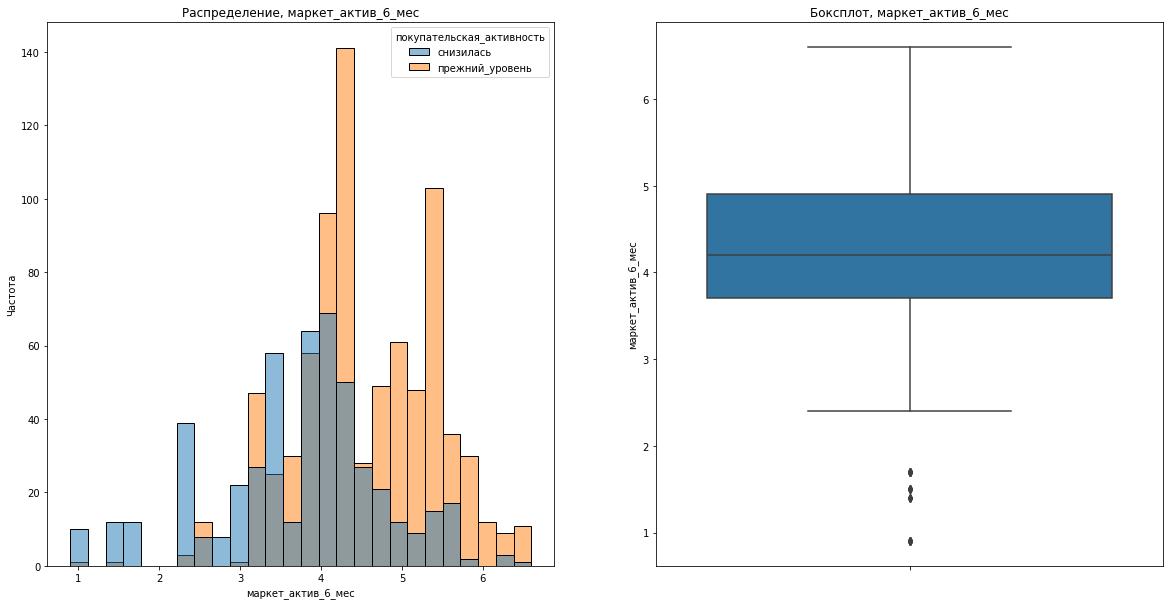

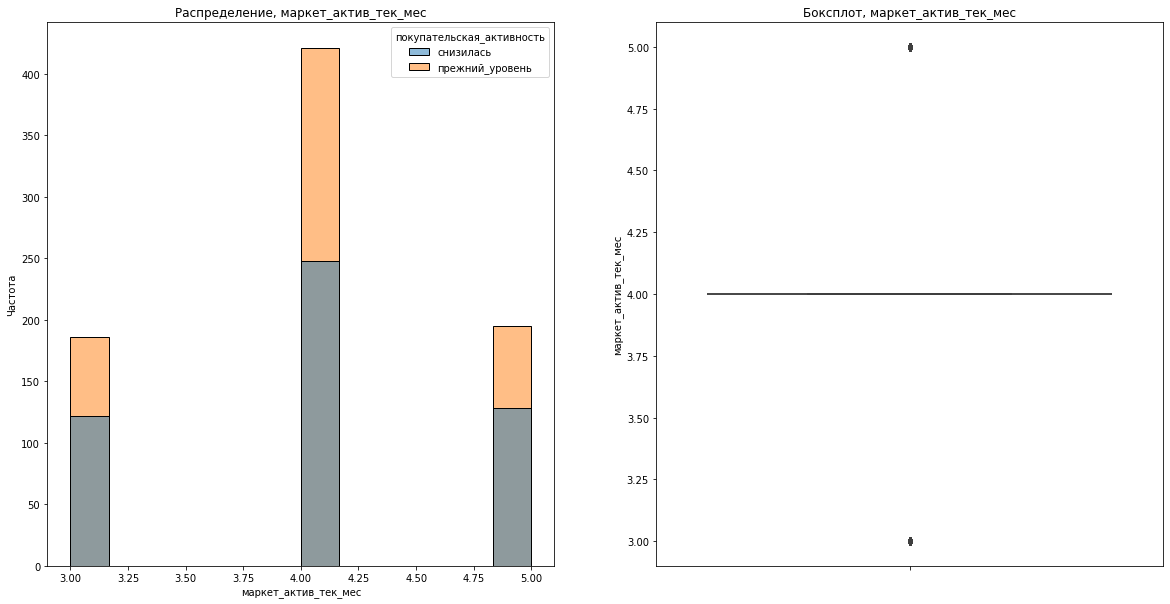

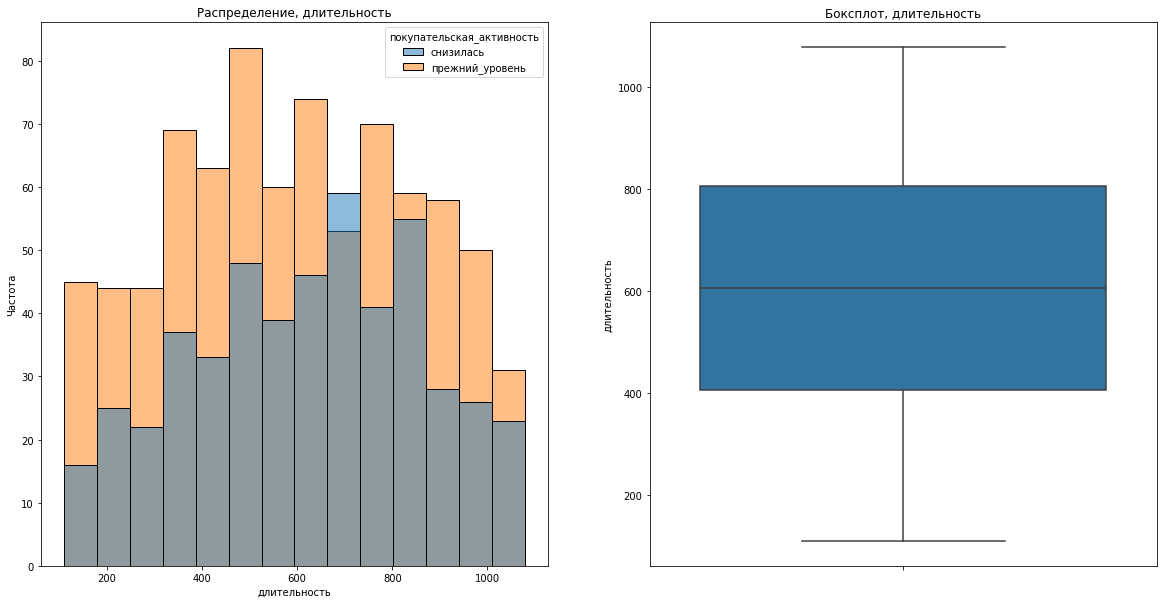

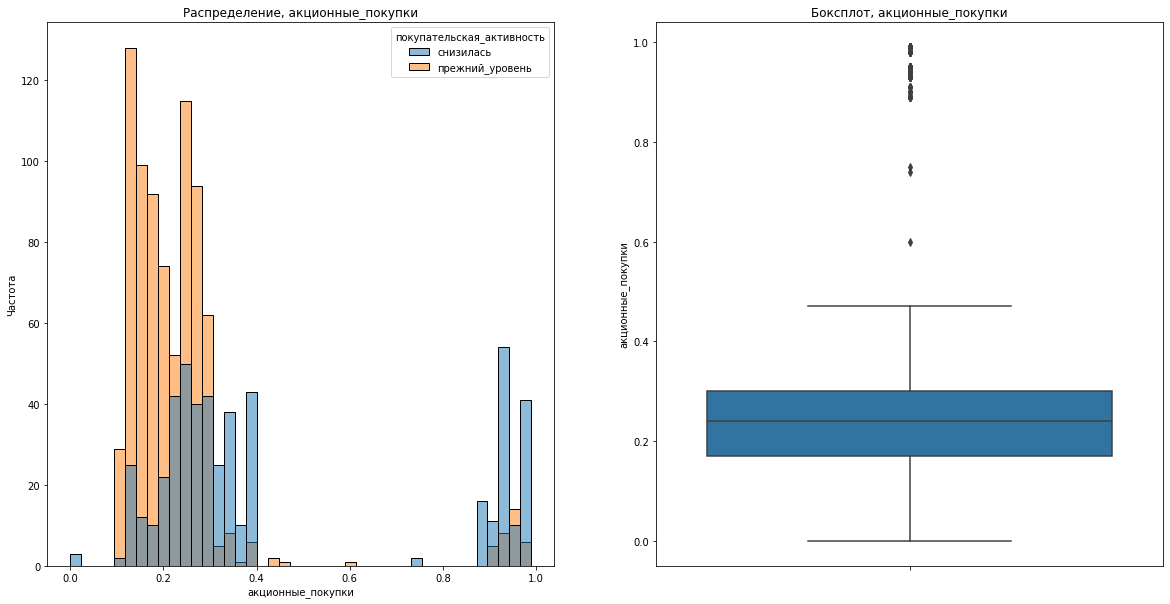

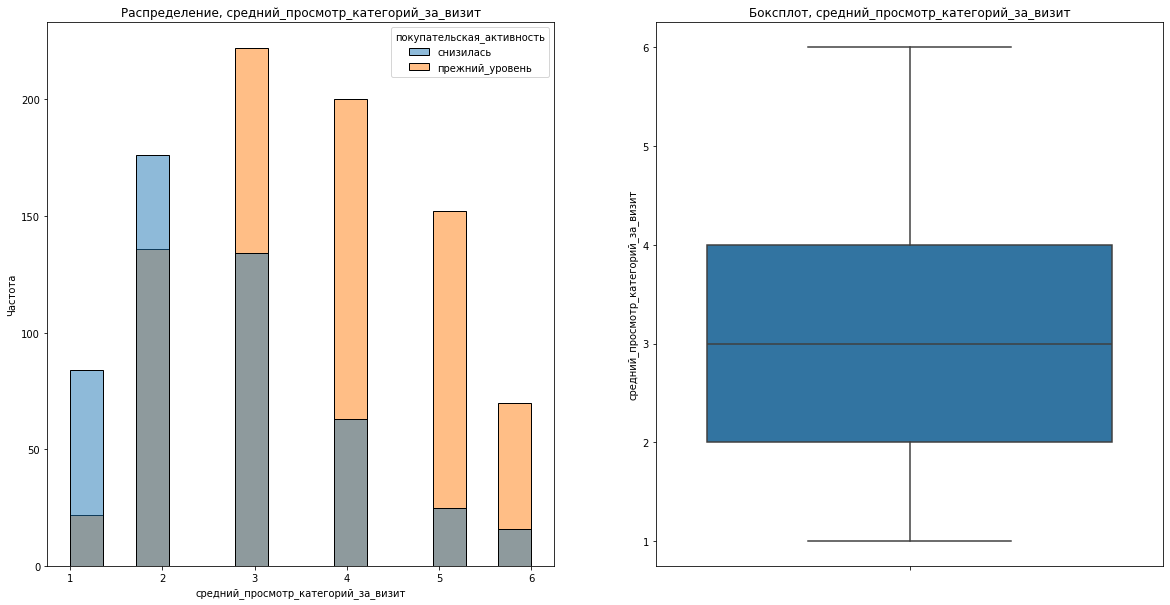

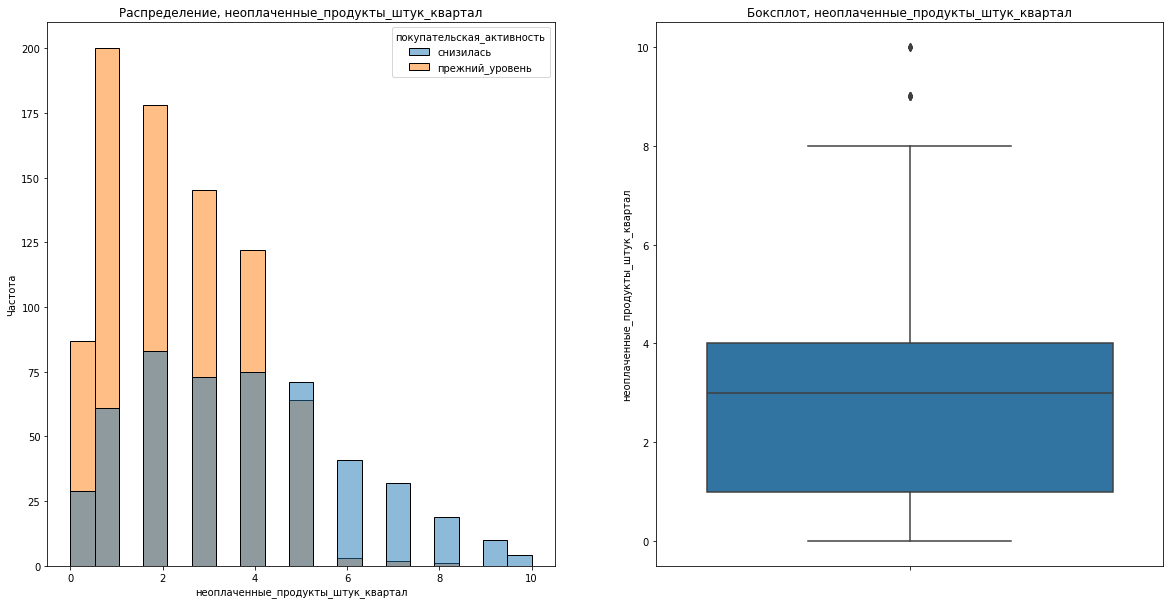

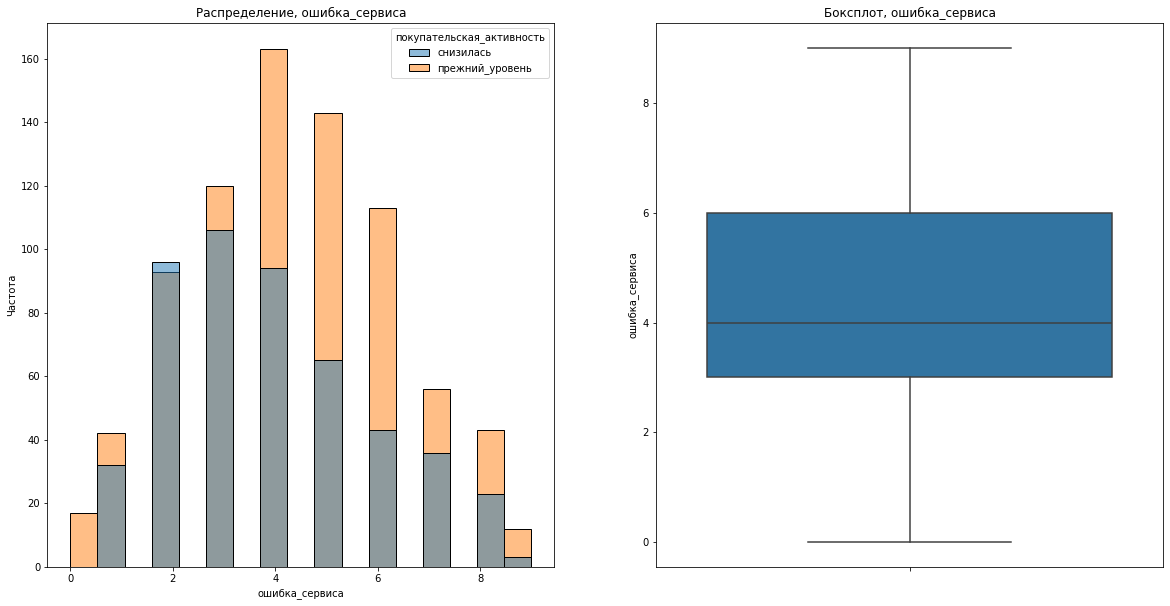

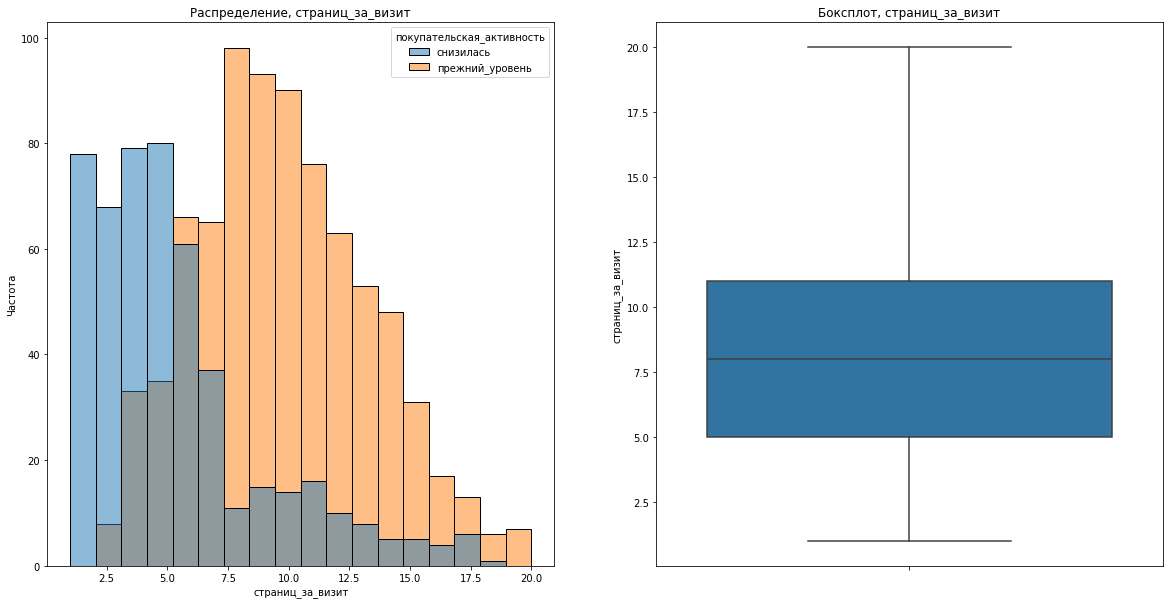

id  маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
count    1300.000000         1300.000000           1300.000000   1300.000000   
mean   215997.500000            4.253769              4.011538    601.898462   
std       375.421985            1.014814              0.696868    249.856289   
min    215348.000000            0.900000              3.000000    110.000000   
25%    215672.750000            3.700000              4.000000    405.500000   
50%    215997.500000            4.200000              4.000000    606.000000   
75%    216322.250000            4.900000              4.000000    806.000000   
max    216647.000000            6.600000              5.000000   1079.000000   

       акционные_покупки  средний_просмотр_категорий_за_визит  \
count        1300.000000                           1300.00000   
mean            0.319808                              3.27000   
std             0.249843                              1.35535   
min             0.000000                              1.00000   
25%             0.170000                              2.00000   
50%             0.240000                              3.00000   
75%             0.300000                              4.00000   
max             0.990000                              6.00000   

       неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  
count                         1300.000000     1300.000000       1300.000000  
mean                             2.840000        4.185385          8.176923  
std                              1.971451        1.955298          3.978126  
min                              0.000000        0.000000          1.000000  
25%                              1.000000        3.000000          5.000000  
50%                              3.000000        4.000000          8.000000  
75%                              4.000000        6.000000         11.000000  
max                             10.000000        9.000000         20.000000

''

In [16]:
# построим графики для таблицы market_file
plots(market_file,'покупательская_активность')
;

id  акционные_покупки  длительность  \
покупательская_активность                                                   
прежний_уровень            216237.761845           0.238367    590.730673   
снизилась                  215610.572289           0.450964    619.883534   

                           маркет_актив_6_мес  маркет_актив_тек_мес  \
покупательская_активность                                             
прежний_уровень                      4.570075              4.011222   
снизилась                            3.744378              4.012048   

                           неоплаченные_продукты_штук_квартал  ошибка_сервиса  \
покупательская_активность                                                       
прежний_уровень                                      2.293017        4.335411   
снизилась                                            3.720884        3.943775   

                           средний_просмотр_категорий_за_визит  \
покупательская_активность                                        
прежний_уровень                                       3.665835   
снизилась                                             2.632530   

                           страниц_за_визит  
покупательская_активность                    
прежний_уровень                    9.796758  
снизилась                          5.568273

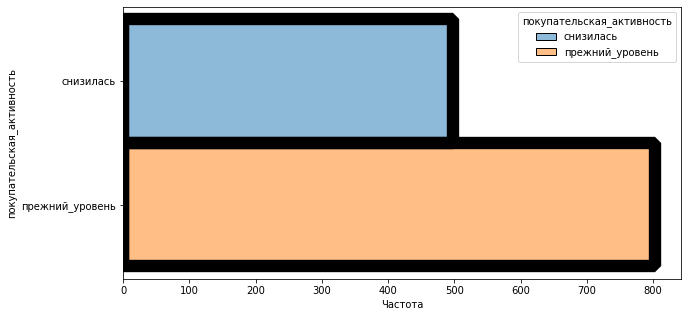

id  акционные_покупки  длительность  \
тип_сервиса                                                   
премиум      215940.494681           0.335851    722.452128   
стандарт     216020.696970           0.313279    552.841991   

             маркет_актив_6_мес  маркет_актив_тек_мес  \
тип_сервиса                                             
премиум                4.115957              3.933511   
стандарт               4.309848              4.043290   

             неоплаченные_продукты_штук_квартал  ошибка_сервиса  \
тип_сервиса                                                       
премиум                                 3.00266        4.263298   
стандарт                                2.77381        4.153680   

             средний_просмотр_категорий_за_визит  страниц_за_визит  
тип_сервиса                                                         
премиум                                 3.005319          8.308511  
стандарт                                3.377706          8.123377

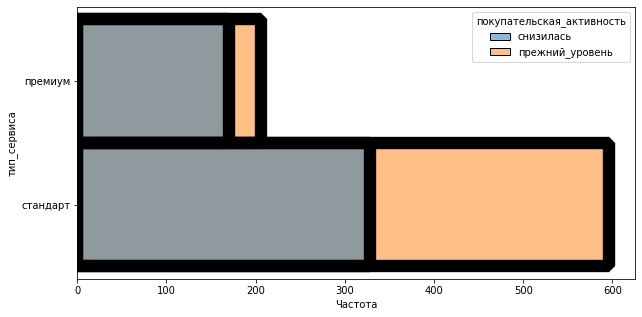

id  акционные_покупки  длительность  \
разрешить_сообщать                                                   
да                  215990.742204           0.316154    632.853430   
нет                 216016.733728           0.330207    513.795858   

                    маркет_актив_6_мес  маркет_актив_тек_мес  \
разрешить_сообщать                                             
да                            4.248960              4.040541   
нет                           4.267456              3.928994   

                    неоплаченные_продукты_штук_квартал  ошибка_сервиса  \
разрешить_сообщать                                                       
да                                            2.923077        4.175676   
нет                                           2.603550        4.213018   

                    средний_просмотр_категорий_за_визит  страниц_за_визит  
разрешить_сообщать                                                         
да                                             3.307692          8.182952  
нет                                            3.162722          8.159763

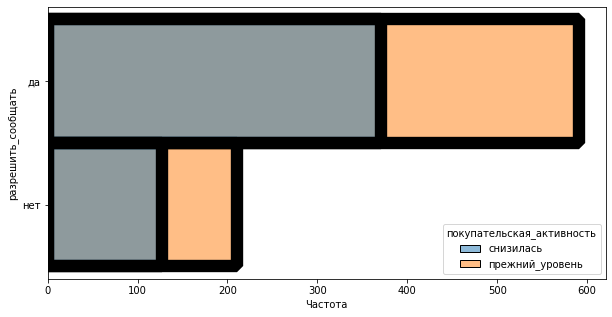

id  акционные_покупки  \
популярная_категория                                                     
домашний_текстиль                     215975.402390           0.299363   
косметика_и_аксесуары                 215956.529148           0.334798   
кухонная_посуда                       215934.652174           0.362101   
мелкая_бытовая_техника_и_электроника  216138.040230           0.269713   
техника_для_красоты_и_здоровья        216064.554348           0.317337   
товары_для_детей                      215956.784848           0.335333   

                                      длительность  маркет_актив_6_мес  \
популярная_категория                                                     
домашний_текстиль                       587.147410            4.212351   
косметика_и_аксесуары                   594.878924            4.211211   
кухонная_посуда                         627.108696            4.083333   
мелкая_бытовая_техника_и_электроника    623.810345            4.552299   
техника_для_красоты_и_здоровья          599.157609            4.334783   
товары_для_детей                        597.293939            4.182727   

                                      маркет_актив_тек_мес  \
популярная_категория                                         
домашний_текстиль                                 3.876494   
косметика_и_аксесуары                             4.040359   
кухонная_посуда                                   4.130435   
мелкая_бытовая_техника_и_электроника              4.028736   
техника_для_красоты_и_здоровья                    4.032609   
товары_для_детей                                  4.024242   

                                      неоплаченные_продукты_штук_квартал  \
популярная_категория                                                       
домашний_текстиль                                               3.318725   
косметика_и_аксесуары                                           2.663677   
кухонная_посуда                                                 3.079710   
мелкая_бытовая_техника_и_электроника                            2.126437   
техника_для_красоты_и_здоровья                                  2.625000   
товары_для_детей                                                2.990909   

                                      ошибка_сервиса  \
популярная_категория                                   
домашний_текстиль                           4.374502   
косметика_и_аксесуары                       4.044843   
кухонная_посуда                             4.028986   
мелкая_бытовая_техника_и_электроника        4.333333   
техника_для_красоты_и_здоровья              4.282609   
товары_для_детей                            4.069697   

                                      средний_просмотр_категорий_за_визит  \
популярная_категория                                                        
домашний_текстиль                                                3.541833   
косметика_и_аксесуары                                            2.932735   
кухонная_посуда                                                  2.898551   
мелкая_бытовая_техника_и_электроника                             3.517241   
техника_для_красоты_и_здоровья                                   3.315217   
товары_для_детей                                                 3.290909   

                                      страниц_за_визит  
популярная_категория                                    
домашний_текстиль                             8.864542  
косметика_и_аксесуары                         7.215247  
кухонная_посуда                               6.840580  
мелкая_бытовая_техника_и_электроника          8.885057  
техника_для_красоты_и_здоровья                8.875000  
товары_для_детей                              8.100000

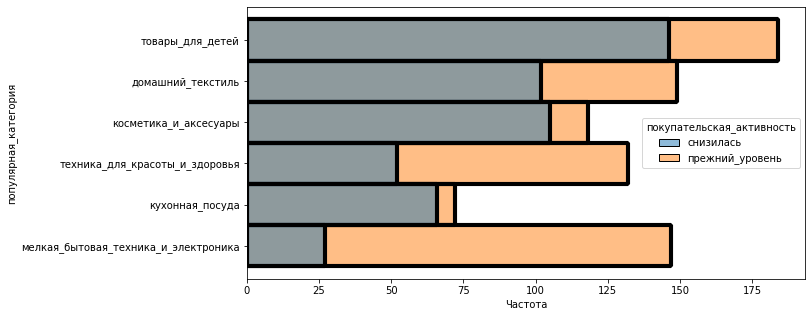

''

In [17]:
# Проанализируем категориальные признаки
plots_cat(market_file,'покупательская_активность')
;

### **Вывод по таблице market_file**
- в первой таблице можно сразу выделить категориальные признаки ('разрешить_сообщать', 'средний_просмотр_категорий_за_визит', 'маркет активность'(2 столбца, можно выбрать границу и разбить на 2 или 3 класса))
- в остальных данных явных аномалий не наблюдается, распределения похожи на нормальные либо имеют некоторое смещение
- в графиках для категориальных признаков аномальных значений не наблюдается


    

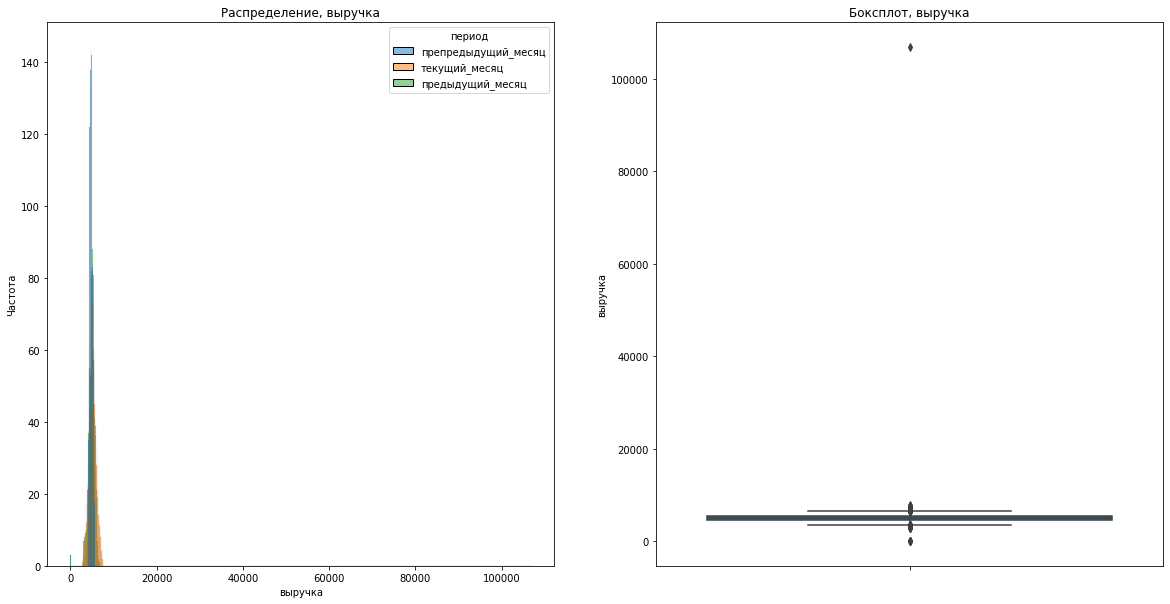

id        выручка
count    3900.000000    3900.000000
mean   215997.500000    5025.696051
std       375.325686    1777.704104
min    215348.000000       0.000000
25%    215672.750000    4590.150000
50%    215997.500000    4957.500000
75%    216322.250000    5363.000000
max    216647.000000  106862.200000

In [18]:
plots(market_money,'период')

In [19]:
# посмотрим на выброс
display(market_money[market_money['выручка']>10000])
;

id         период   выручка
98  215380  текущий_месяц  106862.2

''

In [20]:
market_money = market_money.query('выручка<20000 and выручка>0')
;

''

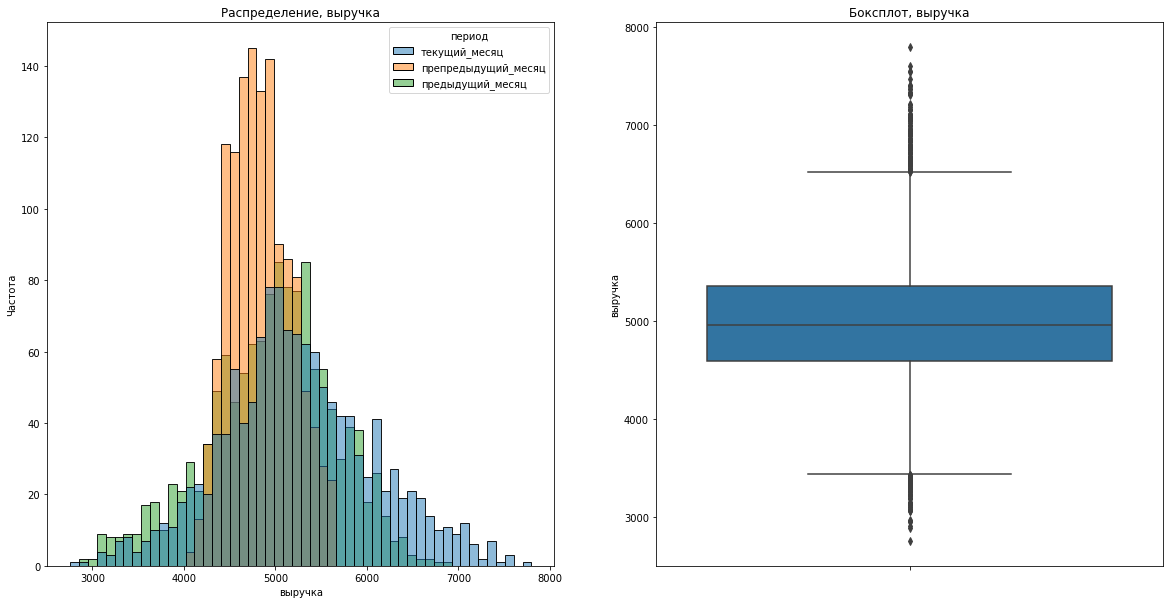

id      выручка
count    3893.000000  3893.000000
mean   215998.649371  5007.282918
std       374.681667   679.724898
min    215348.000000  2758.700000
25%    215674.000000  4592.000000
50%    215999.000000  4959.000000
75%    216323.000000  5363.000000
max    216647.000000  7799.400000

''

In [21]:
plots(market_money,"период")
;

id      выручка
период                                         
предыдущий_месяц     215998.986893  4948.339630
препредыдущий_месяц  215998.986893  4836.367772
текущий_месяц        215997.975366  5236.787452

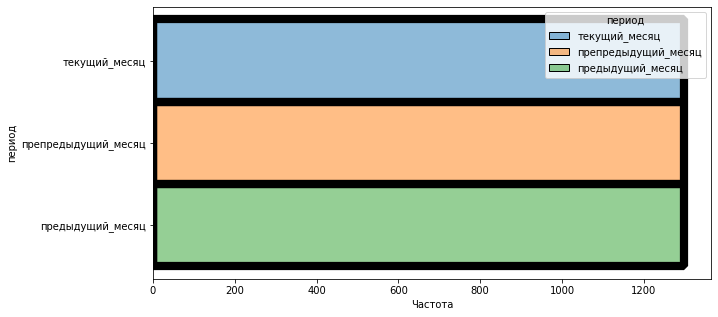

''

In [22]:
# Проанализируем категориальные признаки
plots_cat(market_money,'период')
;

In [23]:
# Выделим клиентов с покупательской активностью не менее трёх месяцев

print(len(market_file))
agg = {'период': ['count']}
group = market_money.groupby('id').agg(agg)
group.columns = ['count']
group = group[group['count'] == 3]
market_file = market_file[market_file['id'].isin(group.index)]
print(len(market_file))
;

1300
1296


''

### **Вывод по таблице market_money**
- был обнаружен выброс, судя по всему пользователь преобрел что-то дорогое, возможно смартфон или телевизор, 
   так как это скорее всего разовая покупка, для корректного анализа эту цифру необходимо удалить 
-  категориальные признаки сопоставимы, выбросов нет
- отфильтровали покупателей с активностью за 3 месяца

In [24]:
display(market_time.head())

id            период  минут
0  215348     текущий_месяц     14
1  215348  предыдущий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдущий_месяц     12
4  215350     текущий_месяц     13

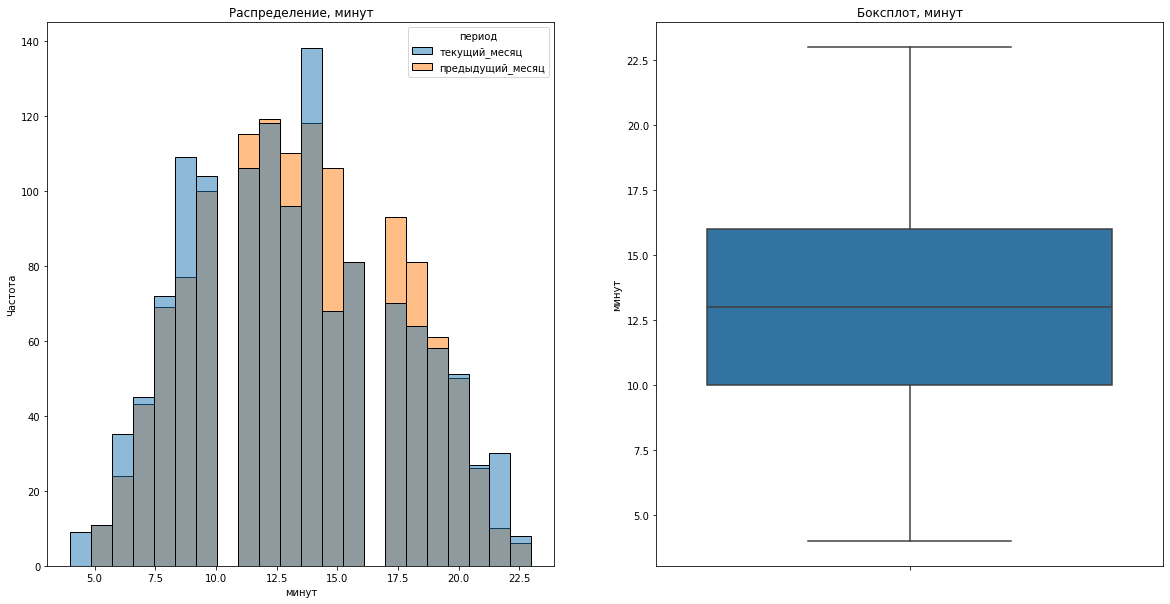

id        минут
count    2600.000000  2600.000000
mean   215997.500000    13.336154
std       375.349754     4.080198
min    215348.000000     4.000000
25%    215672.750000    10.000000
50%    215997.500000    13.000000
75%    216322.250000    16.000000
max    216647.000000    23.000000

''

In [25]:
plots(market_time,'период')
;

id      минут
период                               
предыдущий_месяц  215997.5  13.467692
текущий_месяц     215997.5  13.204615

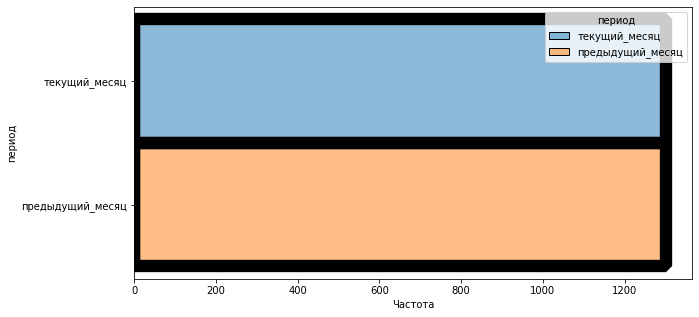

''

In [26]:
# Проанализируем категориальные признаки
plots_cat(market_time,"период")
;

### **Вывод по таблице market_time**
- аномалий в данных не обнаружено, данные распределены нормально
- в категориальных признаках картина такая же , выбросов и аномалий не наблюдается

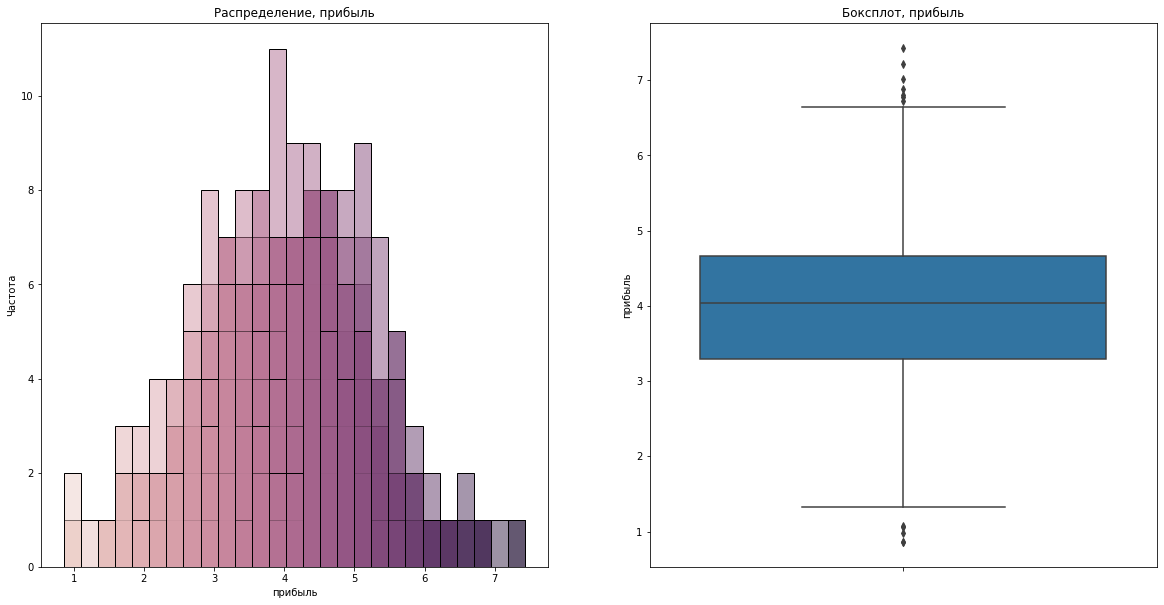

id      прибыль
count    1300.000000  1300.000000
mean   215997.500000     3.996631
std       375.421985     1.013722
min    215348.000000     0.860000
25%    215672.750000     3.300000
50%    215997.500000     4.045000
75%    216322.250000     4.670000
max    216647.000000     7.430000

''

In [27]:
plots(money,'прибыль',legend=False)
;

### **Вывод по таблице money**
- аномалий в данных не обнаружено, данные распределены нормально

### **Общий вывод по исследовательскому анализу** ###


- Исследовательский анализ данных показал что среди данных можно выделить категориальные признаки, 
- было удалено одно аномальное значение, которое могло сильно исказить результаты исследования, 
- судя по графикам большинство данных распределены нормально и готовы  для дальнейшего анализа

## Объединение таблиц

In [28]:
# Заменим индекс в таблицах на  столбец id, для сшивки
market_money_j = market_money.pivot_table(index=['id'], columns=["период"])
market_money_j.columns = ['выручка_за_предыдущий_месяц', 'выручка_за_препредыдущий_месяц', 'выручка_за_текущий_месяц']
market_money_j['id'] = market_money_j.index
market_time_j = market_time.pivot_table(index=['id'], columns=["период"])
market_time_j.columns = ['минут_за_предыдущий_месяц', 'минут_за_текущий_месяц']
market_time_j['id'] = market_time_j.index
# Сшиваем по новому индексу
market_result = market_file.join(market_money_j, on='id', lsuffix="_left", rsuffix="_выручка")
market_result = market_result.rename(columns={'id_left':'id'})
market_result = market_result.join(market_time_j, on='id', lsuffix="_left", rsuffix="_минут")
market_result = market_result.rename(columns={'id_left':'id'})
market_result = market_result.drop(['id_выручка', 'id_минут'], axis=1)
market_result.head(5)
market_result.info()
;

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

''

### **Вывод**

- Обьеденили данные в единую таблицу по id пользователя, можно приступать к следующему этапу

In [29]:
market_result

id покупательская_активность тип_сервиса разрешить_сообщать  \
1     215349                 снизилась     премиум                 да   
2     215350                 снизилась    стандарт                нет   
3     215351                 снизилась    стандарт                 да   
4     215352                 снизилась    стандарт                нет   
5     215353                 снизилась    стандарт                 да   
...      ...                       ...         ...                ...   
1295  216643           прежний_уровень    стандарт                 да   
1296  216644           прежний_уровень    стандарт                нет   
1297  216645           прежний_уровень    стандарт                 да   
1298  216646           прежний_уровень    стандарт                 да   
1299  216647           прежний_уровень     премиум                 да   

      маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
1                    4.4                     4           819   
2                    4.9                     3           539   
3                    3.2                     5           896   
4                    5.1                     3          1064   
5                    3.3                     4           762   
...                  ...                   ...           ...   
1295                 6.6                     3           318   
1296                 5.1                     4           454   
1297                 4.1                     3           586   
1298                 6.3                     5           645   
1299                 4.0                     5           906   

      акционные_покупки            популярная_категория  \
1                  0.75                товары_для_детей   
2                  0.14               домашний_текстиль   
3                  0.99                товары_для_детей   
4                  0.94                товары_для_детей   
5                  0.26               домашний_текстиль   
...                 ...                             ...   
1295               0.24  техника_для_красоты_и_здоровья   
1296               0.21               домашний_текстиль   
1297               0.20               домашний_текстиль   
1298               0.12  техника_для_красоты_и_здоровья   
1299               0.94  техника_для_красоты_и_здоровья   

      средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
1                                       4                                   4   
2                                       5                                   2   
3                                       5                                   0   
4                                       3                                   2   
5                                       4                                   1   
...                                   ...                                 ...   
1295                                    5                                   3   
1296                                    6                                   2   
1297                                    3                                   2   
1298                                    3                                   3   
1299                                    4                                   5   

      ошибка_сервиса  страниц_за_визит  выручка_за_предыдущий_месяц  \
1                  2                 5                       5216.0   
2                  1                 5                       5457.5   
3                  6                 4                       6158.0   
4                  3                 2                       5807.5   
5                  1                 4                       4738.5   
...              ...               ...                          ...   
1295               3                11                       3664.0   
1296               3                 9                       4729.0   
1297               5                 7     

## Корреляционнный анализ

interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_за_предыдущий_месяц', 'выручка_за_препредыдущий_месяц', 'выручка_за_текущий_месяц', 'минут_за_предыдущий_месяц', 'минут_за_текущий_месяц']


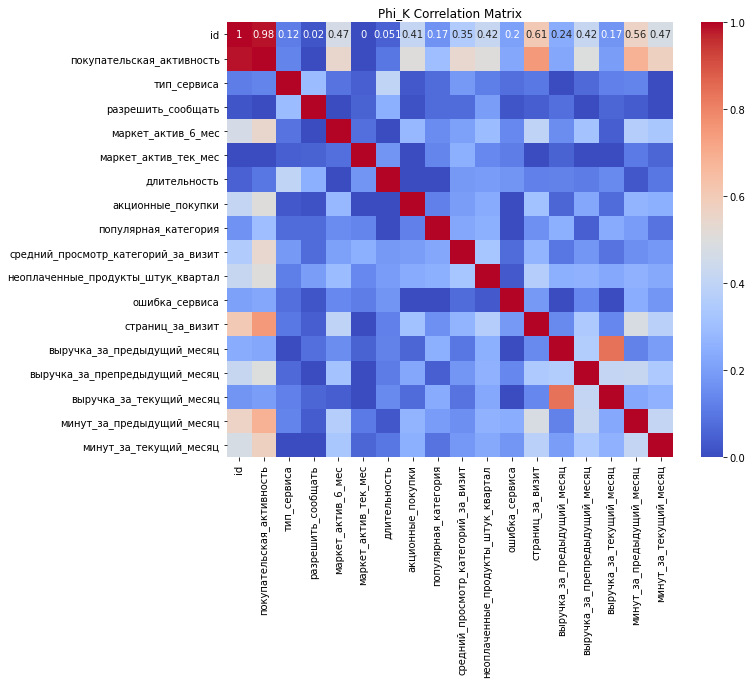

''

In [30]:
# Вычисление матрицы корреляции с использованием phik
for_heatmap = market_result.drop('id', axis=1)
corr_matrix = market_result.phik_matrix()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()
;

''

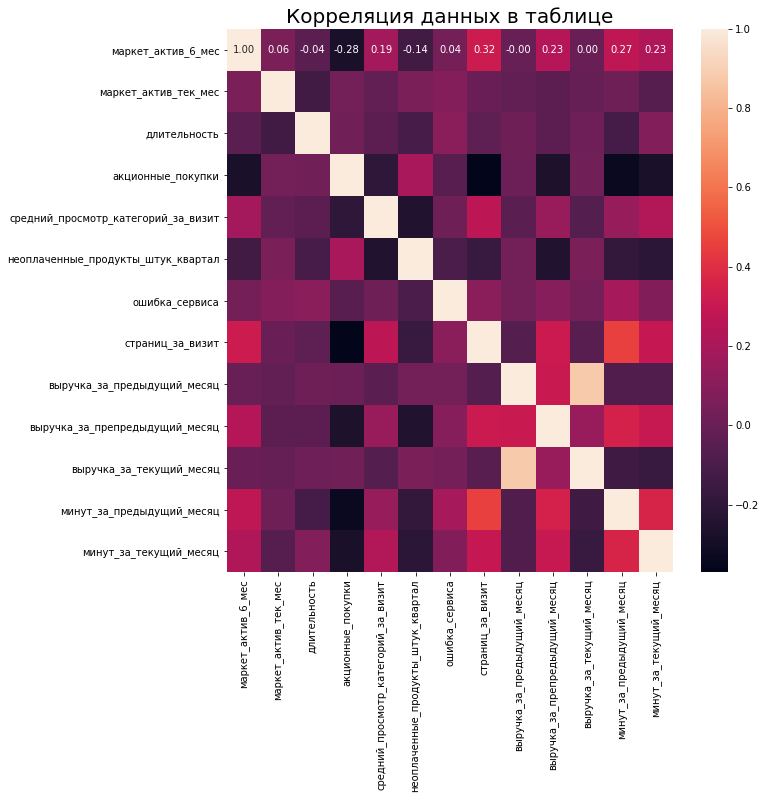

In [31]:
plt.figure(figsize=(10, 10))
plt.title('Корреляция данных в таблице', fontsize=20)
sns.heatmap(for_heatmap.corr(method="spearman"), annot=True, fmt='.2f')
;

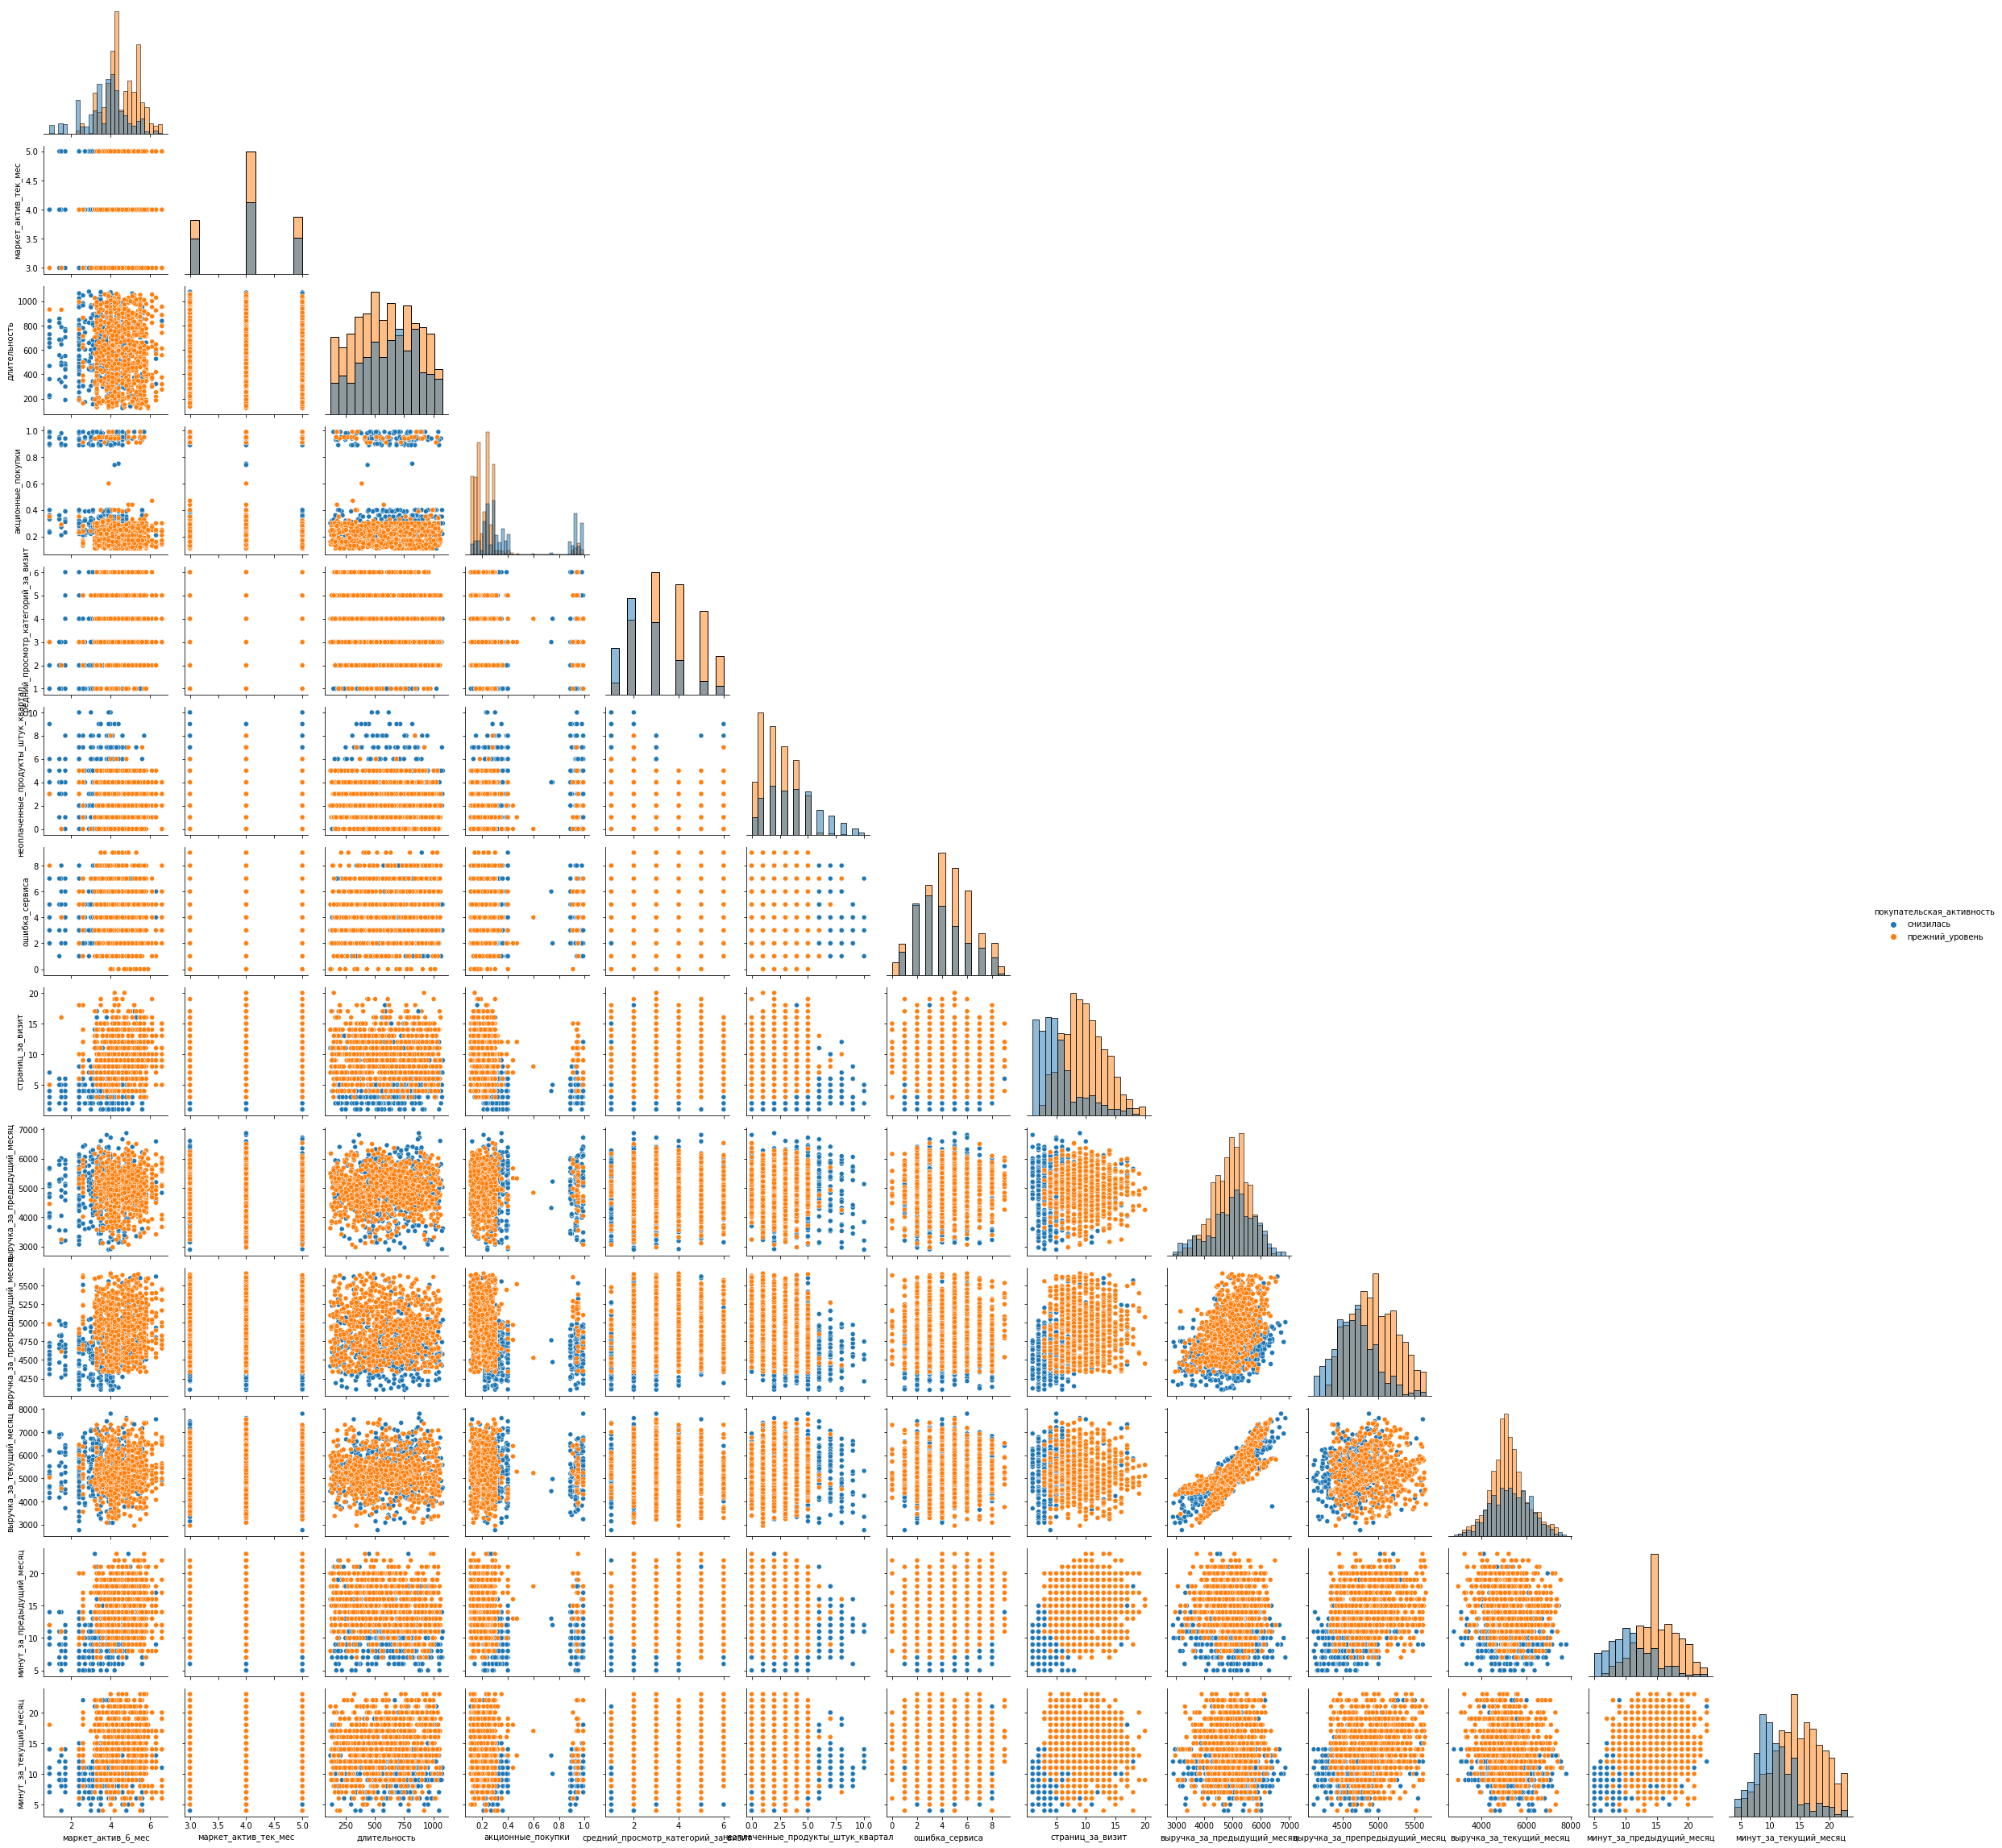

In [32]:
g = sns.PairGrid(for_heatmap, hue="покупательская_активность",diag_sharey=False, corner=True)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

    Целевой признак "Покупательская активность", phik корреляция показывает, какая-либо связь наблюдается с признаками: 
 - 'минут_за_текущий_месяц', 
 - 'минут_за_предыдущий_месяц',
 - 'страниц_за_визит',
 - 'неоплаченные_продукты_штук_квартал', 
 - 'средний_просмотр_категорий_за_визит', 
 - 'акционные_покупки', 
 - 'маркет_актив_6_мес'


### **Вывод**

- Обнаружена достаточно надежная связь целевого признака с проведенным временем в интернет магазине, акциями, с количеством просмотренных товаров и категорий, тоесть с активностью пользователя
- Мультиколлениарности признаков не обнаружено

## Использование пайплайнов

- Необходимо настроить пайплайн для проверки и настройки разных моделей, в результате мы определим лучшую из них и предложим заказчику лучшую модель 

In [33]:
# Определим столбцы для масштабирования
ohe_columns = ['разрешить_сообщать', 'популярная_категория', 'тип_сервиса']
ord_columns = ['акционные_покупки']
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'маркет_актив_тек_мес', 
               'длительность', 'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 
               'выручка_за_предыдущий_месяц', 'выручка_за_препредыдущий_месяц', 'выручка_за_текущий_месяц', 
               'минут_за_предыдущий_месяц', 'минут_за_текущий_месяц']
;

''

In [34]:
# Преобразуем целевой признак
market_result['покупательская_активность'] = market_result['покупательская_активность'].replace('снизилась',0).replace('прежний_уровень',1)
market_result['покупательская_активность'] = market_result['покупательская_активность'].astype(int)
# На ггистограмме распределения Акционных покупок можно выделить 2 категории, что мы сейччас и сделаем для корректного поиска связи
market_result['акционные_покупки'] = market_result['акционные_покупки'].apply( lambda x: 'Постоянно покупает по акции' if x>= 0.5 else 'Иногда покупает по акции' )
market_result = market_result.set_index('id')
display(market_result.head(5))
;

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                 
215349                          0     премиум                 да   
215350                          0    стандарт                нет   
215351                          0    стандарт                 да   
215352                          0    стандарт                нет   
215353                          0    стандарт                 да   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215349                 4.4                     4           819   
215350                 4.9                     3           539   
215351                 3.2                     5           896   
215352                 5.1                     3          1064   
215353                 3.3                     4           762   

                  акционные_покупки популярная_категория  \
id                                                         
215349  Постоянно покупает по акции     товары_для_детей   
215350     Иногда покупает по акции    домашний_текстиль   
215351  Постоянно покупает по акции     товары_для_детей   
215352  Постоянно покупает по акции     товары_для_детей   
215353     Иногда покупает по акции    домашний_текстиль   

        средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215350                                    5   
215351                                    5   
215352                                    3   
215353                                    4   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215350                                   2               1                 5   
215351                                   0               6                 4   
215352                                   2               3                 2   
215353                                   1               1                 4   

        выручка_за_предыдущий_месяц  выручка_за_препредыдущий_месяц  \
id                                                                    
215349                       5216.0                          4472.0   
215350                       5457.5                          4826.0   
215351                       6158.0                          4793.0   
215352                       5807.5                          4594.0   
215353                       4738.5                          5124.0   

        выручка_за_текущий_месяц  минут_за_предыдущий_месяц  \
id                                                            
215349                    4971.6                         12   
215350                    5058.4                          8   
215351                    6610.4                         11   
215352                    5872.5                          8   
215353                    5388.5                         10   

        минут_за_текущий_месяц  
id                              
215349                      10  
215350                      13  
215351                      13  
215352                      11  
215353                      10

''

In [35]:
# Разобьем выборку на обучающую и тестовую
X = market_result.drop(['покупательская_активность'], axis=1)
y = market_result['покупательская_активность']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)
;

''

In [36]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['Иногда покупает по акции','Постоянно покупает по акции'], 
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,8),
        'models__max_features': range(2,8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly')],
        'models__degree': range(2, 3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]
;


''

In [37]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
display(randomized_search.fit(X_train, y_train))
;

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['разрешить_сообщать',
                                                                                'популярная_категория',
                                                                                'тип_сервиса']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleIm...
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        random_state=42)],
                                         'models__degree': range(2, 3),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

''

In [38]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке при кроссвалидации:', round(randomized_search.best_score_, 2))
;

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория',
                                                   'тип_сервиса']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   Si

''

In [39]:
# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_proba[:,1]), 2)}')
;

Метрика ROC-AUC на тестовой выборке: 0.9


''

In [40]:
print(f'Метрика F1-score на тестовой выборке: {round(f1_score(y_test, y_test_pred, average="macro"), 2)}')
;

Метрика F1-score на тестовой выборке: 0.85


''

### **Вывод** ###

- Лучшие результаты показала модель LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear'). 
- Метрика roc_auc для тренировочной выборки с результатом 0.9, для тестовой выборки также 0.9. 
- Метрика f1 показала 0.85.

**Выбрали метрику roc-auc потому что**:

    - ROC-кривая учитывает не только результаты классификации, но и вероятность предсказания всех классов. Например, если результат корректно классифицирован на основе 51% вероятности, то он, скорее всего, будет классифицирован неверно, если вы воспользуетесь другим тестовым датасетом. 
    - Кроме того, ROC-кривая также учитывает эффективность модели при различных пороговых значениях. Она является комплексной метрикой для оценки того, насколько хорошо разделяются случаи в разных группах.

Дисбаланс классов не помешал высокие значения метрик.

## Анализ важности признаков

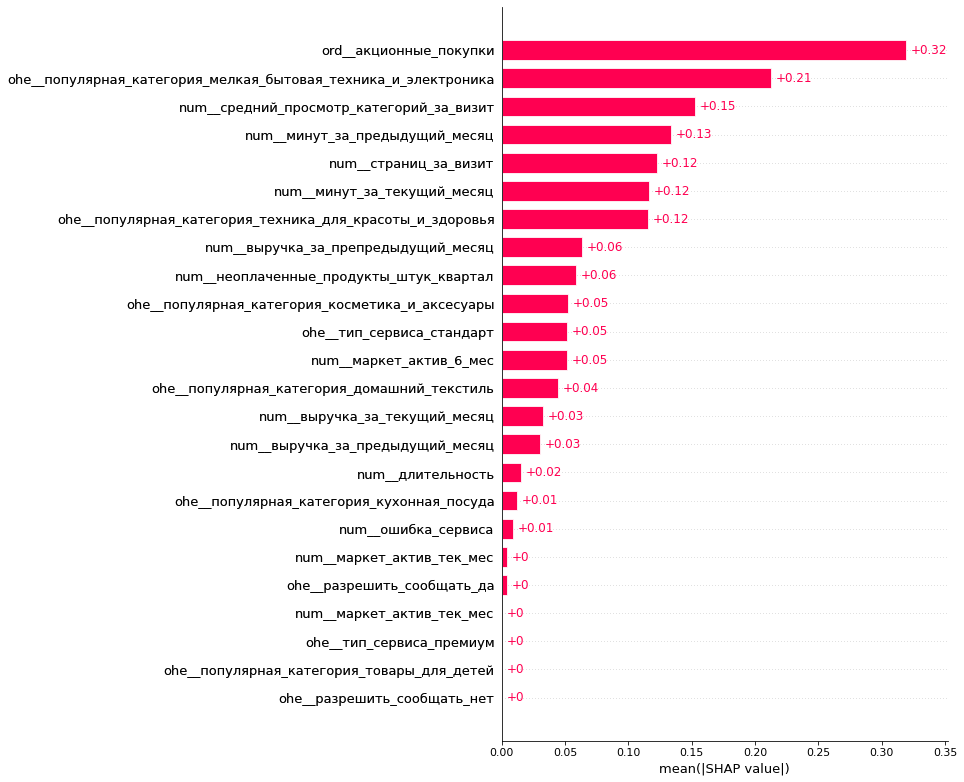

None

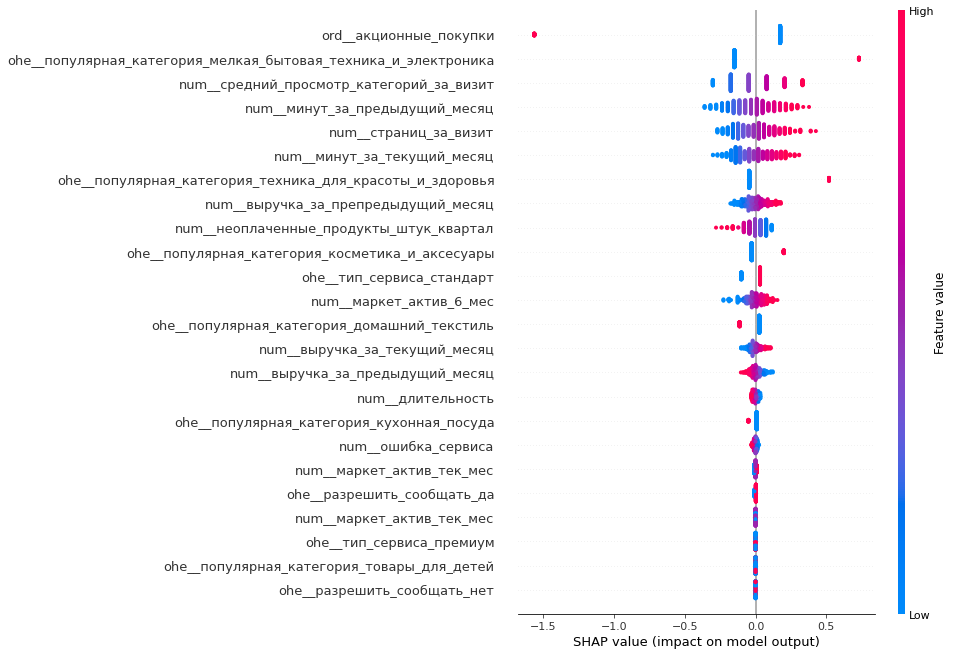

None

''

In [41]:
X_train_new = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'], X_train_new)
X_test_new = pipe_final.named_steps['preprocessor'].transform(X_test)
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test_new = pd.DataFrame(X_test_new, columns=feature_names)
shap_values = explainer(X_test_new)

display(shap.plots.bar(shap_values, max_display=30))
display(shap.plots.beeswarm(shap_values, max_display=30))
;

### **Вывод** ###

Наибольшее влияние на модель оказывают параметры: 
- 'акционные_покупки'
- 'популярная_категория_мелкая_бытовая_техника_и_электроника',
- 'популярная_категория_техника_для_красоты_и_здоровья',
- 'средний_просмотр_категорий_за_визит',
- 'страниц_за_визит',
- 'минут_за_предыдущий_месяц',
- 'минут_за_текущий_месяц', 

Это легко обьясняется, 

- чем больше времени мы проводим и больше смотрим, то скорее всего мы ищем что-то конкретное и готовы это купить, 
- возможно мы что-то искали давно и нашли и решили купить, яем больше времени проводим в магазине, тем более вероятно что мы найдем то что нам нужно, 
- тем более если есть какая-либо акция

как можно использовать эту информацию, 
- необходима стараться удерживать внимание пользователей которые меньше времени проводят в магазине, проанализировать какие они товары покупают, возможно предложить акции на эти товары, сделать накопительный бонус за покупки





##  Сегментация покупателей

    - Для сегментации результатов моделирования и прибылности покупателей, нелюходимо изучить данные четвертой таблицы, результаты можелирования будем объеденим в таблицу  

In [42]:
money = money.set_index('id')
;

''

In [43]:
y_test_proba = randomized_search.predict_proba(X_test)[:,0]
y_train_proba = randomized_search.predict_proba(X_train)[:,0]
X_test_money = X_test[X_test.columns]
X_train_money = X_train[X_train.columns]
X_test_money['вероятность_снижения'] = y_test_proba
X_train_money['вероятность_снижения'] = y_train_proba
#Объеденим таблицы
df_money = pd.concat([X_train_money, X_test_money])
df_money = df_money.join(money)
display(df_money.head(5))
;

тип_сервиса разрешить_сообщать  маркет_актив_6_мес  \
id                                                          
215761    стандарт                нет                 5.7   
216625    стандарт                 да                 3.4   
215375     премиум                 да                 3.0   
215390    стандарт                 да                 3.1   
215985    стандарт                 да                 5.5   

        маркет_актив_тек_мес  длительность            акционные_покупки  \
id                                                                        
215761                     4           565     Иногда покупает по акции   
216625                     5           351     Иногда покупает по акции   
215375                     4           558  Постоянно покупает по акции   
215390                     4           152     Иногда покупает по акции   
215985                     5           541     Иногда покупает по акции   

                        популярная_категория  \
id                                             
215761                     домашний_текстиль   
216625                       кухонная_посуда   
215375                      товары_для_детей   
215390                 косметика_и_аксесуары   
215985  мелкая_бытовая_техника_и_электроника   

        средний_просмотр_категорий_за_визит  \
id                                            
215761                                    5   
216625                                    5   
215375                                    3   
215390                                    6   
215985                                    4   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215761                                   1               4                12   
216625                                   1               6                 8   
215375                                   3               7                 4   
215390                                   4               2                 5   
215985                                   1               6                 5   

        выручка_за_предыдущий_месяц  выручка_за_препредыдущий_месяц  \
id                                                                    
215761                       4252.0                          5023.0   
216625                       4337.0                          4949.0   
215375                       5253.5                          4715.0   
215390                       4254.0                          4549.0   
215985                       5388.0                          5223.0   

        выручка_за_текущий_месяц  минут_за_предыдущий_месяц  \
id                                                            
215761                    3713.8                         12   
216625                    5000.0                         15   
215375                    5633.1                          8   
215390                    4612.8                          8   
215985                    5661.0                         12   

        минут_за_текущий_месяц  вероятность_снижения  прибыль  
id                                                             
215761                      18              0.034001     2.60  
216625                      13              0.116512     4.12  
215375                       9              0.987076     4.18  
215390                      12              0.574422     5.70  
215985                      11              0.117451     6.78

''

- Необходимо выполнить сегментацию покупателей.

Хотелось бы учесть:

    Чаще всего женщины покупают то, что проще заказать из интернет магазина какую-то мелочь, товары для красоты.
    Мужчины в основном покупают мелкую электронику.
    
В качестве рекомендации, предложил бы заказчику, собирать данные по полу пользователей, чтобы более качественно настроить рекомендации и получать лучший прогноз. Товары которые заказывают мужчины и женщины кординально отличаются, 


Попробуем выделить категорию людей которые заказывают товары для красоты и рассмотрим их отдельно! Считаю что это может оказаться наиболее прибыльным

In [44]:
# Функция построения графиков
def cross_plots(table):
    cat_columns = list(table.select_dtypes(include='object').columns)
    for cat in cat_columns:
        fig = plt.figure(figsize=(25,10))
        plt.subplot(1,2, 1)
        sns.scatterplot(data=table, y='прибыль', x='вероятность_снижения', hue=cat)
        plt.xlabel('Вероятность снижения активности')
        plt.ylabel('Выручка от пользователя')
        plt.title('Связь вероятности снижения активности и выручки')
        plt.subplot(1,2, 2)
        sns.histplot(data=table, y=cat, hue=cat)
        plt.xlabel('Частота')
        plt.title('Гистограмма частот')
        plt.show()
;
            

''

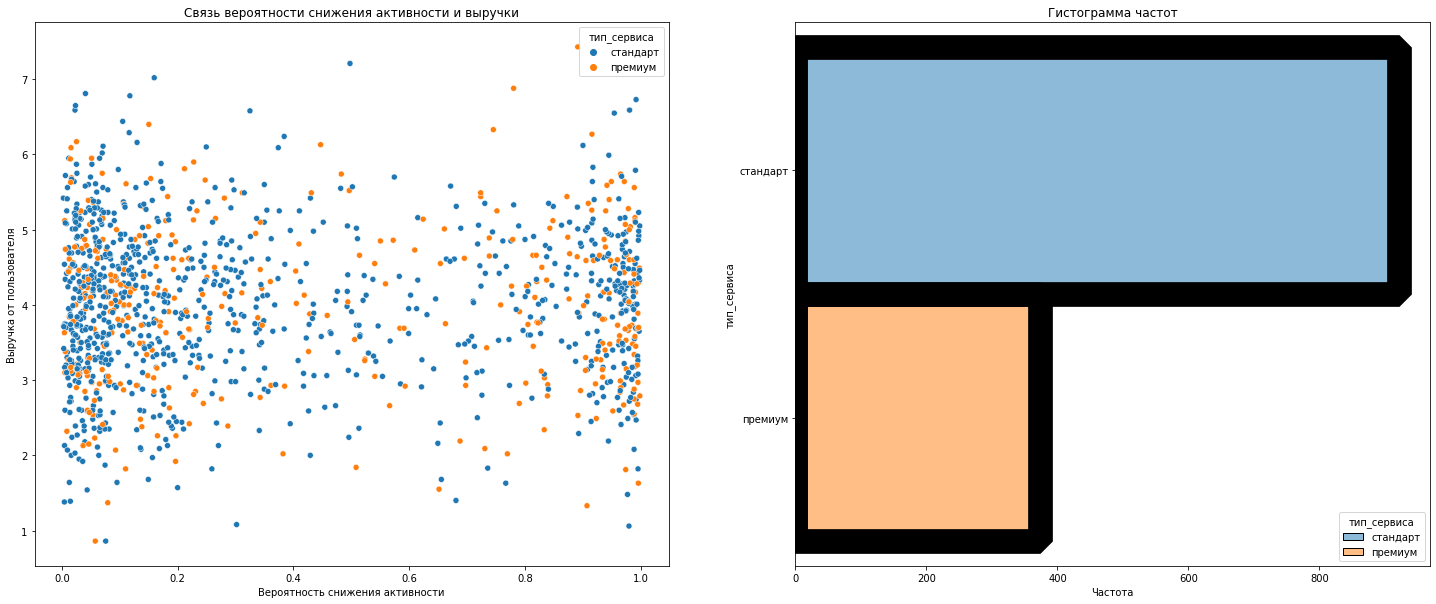

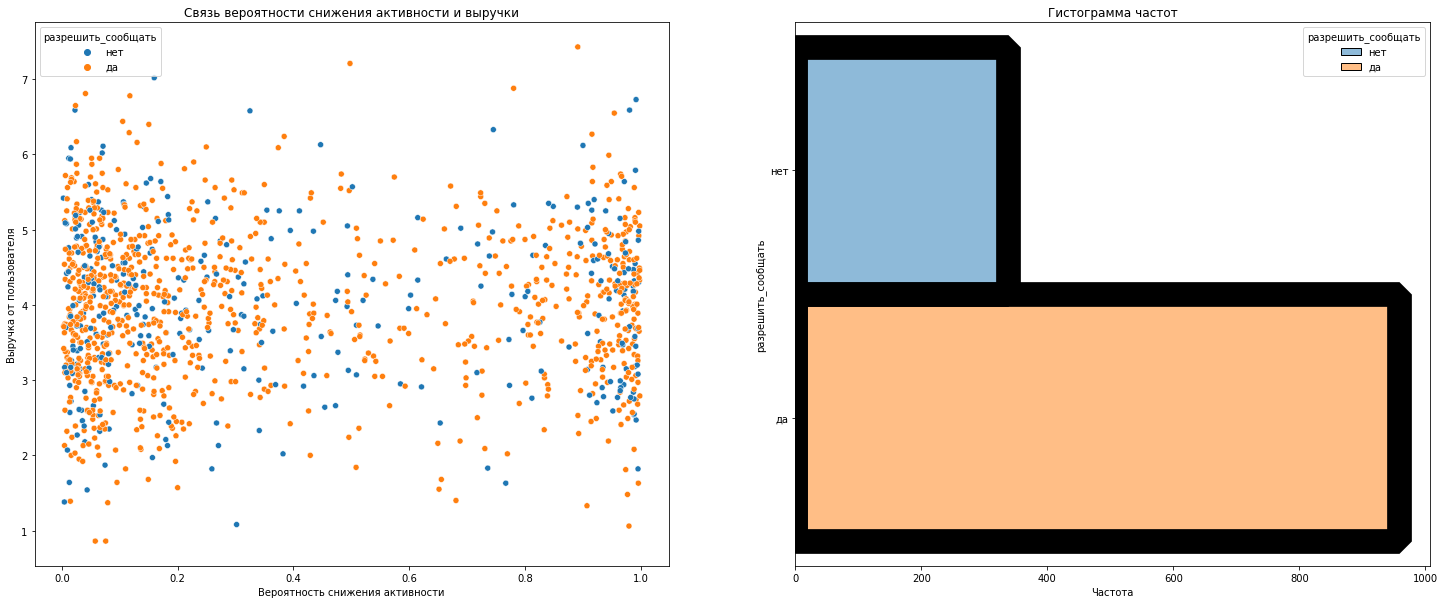

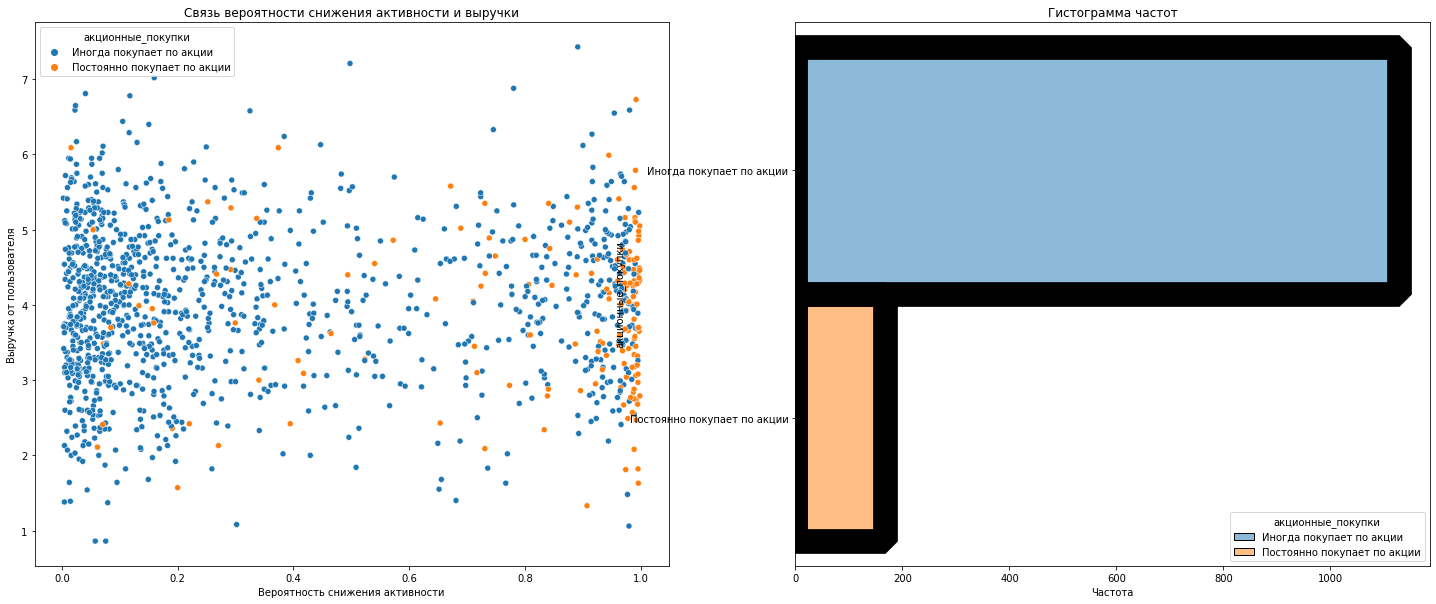

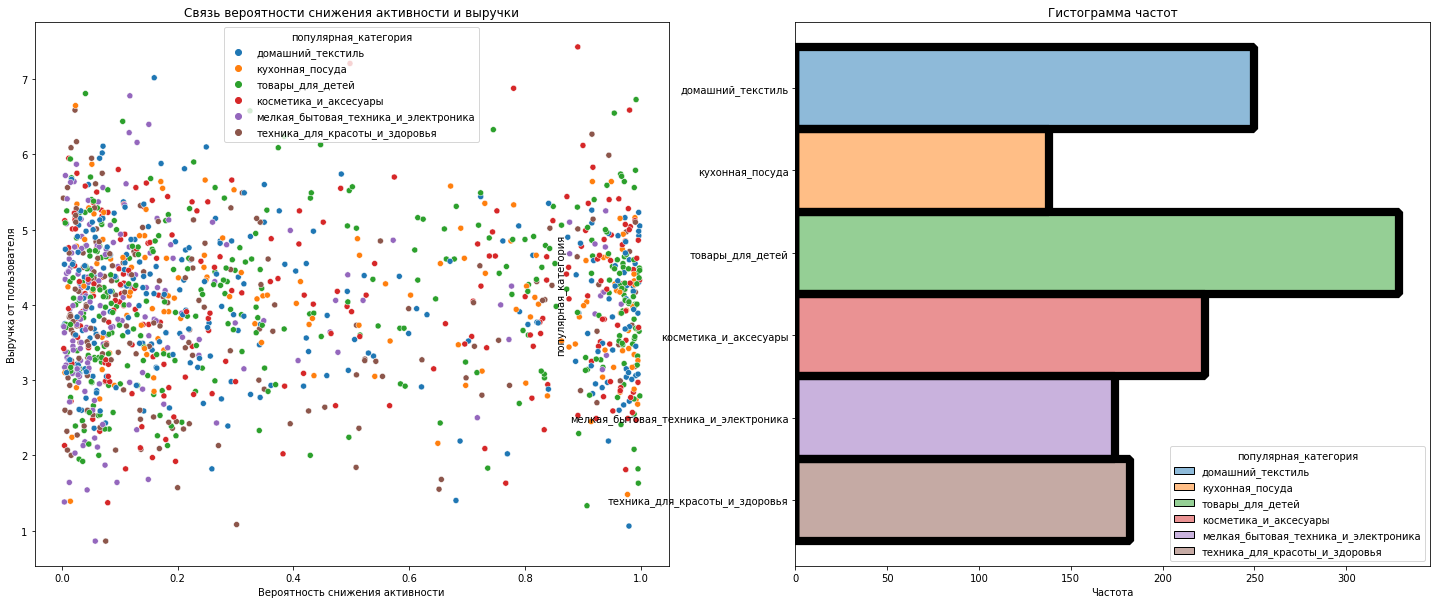

''

In [45]:
cross_plots(df_money)
;

По графикам можно сделать следующие выводы:
    
- явная связь с веротностью снижения активности имеют пользователи которые постоянно покупают товары по акциям,  это может быть связано с тем, что эти пользователи ищут акции для покупок на те товары которые им нужны, если не находят акциию, то не покупают и покупательская активность снижается до следующего акционного периода 

- рассмотрим отдельно категорию "товары для детей" и "косметика и аксесуары" (сделаем предположение что эти товары покупают покупатели женского пола)

    

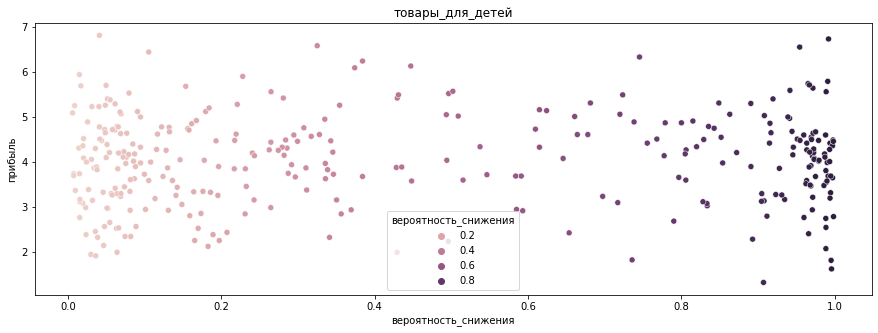

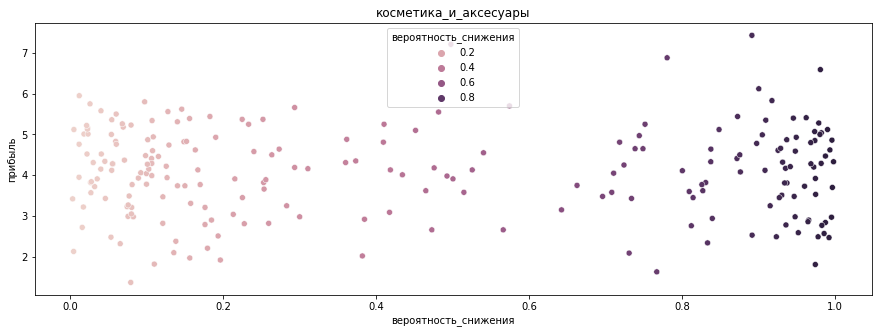

''

In [46]:
# Посмотрим распределение вероятностей по эти категориям
for cat in ['товары_для_детей','косметика_и_аксесуары']:
    name = 'df_'+str(cat)
    name = df_money.copy()
    name = name[name['популярная_категория'] == cat]
    fig = plt.figure(figsize=(15,5))
    sns.scatterplot(data=name, y='прибыль', x='вероятность_снижения', hue='вероятность_снижения')
    plt.title(cat)
    plt.show()
;

### **Вывод** ###

- Примерно одинаковое количество покупателей в этих категориях имеют высокую вероятность снижения активности, при этом они приносят достаточно высокую прибыль, если посмотреть на дисперсию значений с высокой вероятностью снижения активности, 

- Очевидно что товары для детей со временем становятся неактуальны для одних и тех же пользователей (дети взрослеют), но при этом это самая популярная категория,
- можно отталкиваться от того что категория товары для детей для нас наибольшая аудитория для рекомендация других категорий, тем более мы уже знаем что это семья скорее всего минимум из 3 человек, что дает нам дополнительные варианты предложений и рекомендации этим пользователям, 
- косметика также высокоприбыльная область, по ней предложил бы проводить колоборации с различными популярными брендами, возможно привлеч блогеров, для того чтобы удерживать аудиторию, которая приносит высокую прибыль
    

## **Общий вывод** ##

- Целью данного иссследования было построение модели для предсказания уменьшение покупательской активности покупателей интернет-магазина "В один клик",
- также выделить сегмент покупателей, проанализировать его и предложить, как увеличить его покупательскую активность.


- Этап 1:
    - Загрузили данные, в 4 таблицы:
        первая таблица содержит 1300 строки и 13 столбцов, пропусков нет
        вторая таблица содержит 3900 строк и 3 столбца, пропусков нет
        третья таблица содержит 2600 строк и 3 столбцов, пропусков нет
        четвертая таблица содержит 1300 строк и 2 столбцов, пропусков нет
    
    
- Этап 2 включал:
    - выполнили предобработку данных: 
        - проверили на неявные (в столбце "тип_сервиса"  и 'период' устранили неявный дубликат)
        - преобразовали типы данных в корректные
    - подготовили данные к дальнешему анализу
    
    
- Этап 3 включал: 
    - Исследовательский анализ данных показал что среди данных можно выделить категориальные признаки, 
    - было удалено одно аномальное значение, которое могло сильно исказить результаты исследования 
    
    
- На 4 этапе: 
    - Объеденили данные в единую таблицу по id пользователя
    
    
- На 5 этапе: Нашли связь целевого признака с данными
    - Обнаружена достаточно надежная связь целевого признака с проведенным временем в интернет магазине, акциями, с количеством просмотренных товаров и категорий, тоесть с активностью пользователя
    - Мультиколлениарности признаков не обнаружено
    
    
- На 6 этапе: Обучили модель посчитали метрики на прогнозных данных
    - Лучшие результаты показала модель LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear'). 
    - Метрика roc_auc для тренировочной выборки с результатом 0.9, для тестовой выборки также 0.9. 
    - Метрика f1 показала 0.85
    - Дисбаланс классов не помешал высокие значения метрик.
    
    
- На 7 этапе: Выявили категории которые лучше прогнозируют снижение активности
    Наибольшее влияние на модель оказывают параметры: 
    - 'акционные_покупки'
    - 'популярная_категория_мелкая_бытовая_техника_и_электроника',
    - 'популярная_категория_техника_для_красоты_и_здоровья',
    - 'средний_просмотр_категорий_за_визит',
    - 'страниц_за_визит',
    - 'минут_за_предыдущий_месяц',
    - 'минут_за_текущий_месяц', 

    Это легко обьясняется, 

    - чем больше времени мы проводим и больше смотрим, то скорее всего мы ищем что-то конкретное и готовы это купить, 
    - возможно мы что-то искали давно и нашли и решили купить, чем больше времени проводим в магазине, тем более вероятно что мы найдем то что нам нужно, 
    - тем более если есть какая-либо акция

    как можно использовать эту информацию, 
    - необходима стараться удерживать внимание пользователей которые меньше времени проводят в магазине, проанализировать какие они товары покупают, возможно предложить акции на эти товары, сделать накопительный бонус за покупки
    
    
    
- На 8 этапе: Выявили приоритетные категории которые мы можем достаточно подробно изучить и постараться удержать и привлечь этих клиентов в другие категории
    - товары для детей
    - косметика и аксесуары,
       
 